# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [ ]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import matplotlib.pyplot as plt
import pandas as pd
import os
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-10-01 20:11:12--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.24, 52.219.113.40, 52.219.117.136, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  47.6MB/s    in 27s     

2023-10-01 20:11:41 (40.3 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg 

In [4]:
#Upload data to S3 bucket
sagemaker_session = sagemaker.Session()
BUCKET = sagemaker_session.default_bucket()
PREFIX  = 'AWS-IC-Project/dog-breed-dataset'
CURRENT_DIR = 'dogImages'

In [5]:
dataset_path = sagemaker_session.upload_data(
    path = CURRENT_DIR,
    bucket = BUCKET,
    key_prefix = PREFIX
)

print(dataset_path)

s3://sagemaker-us-east-1-379471544283/AWS-IC-Project/dog-breed-dataset


In [6]:
dataset_path_dir = dataset_path
role = sagemaker.get_execution_role(sagemaker_session=sagemaker_session)

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": CategoricalParameter([1, 2])
}



objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [8]:
#TODO: Create estimators for your HPs
cwd = os.getcwd()

estimator = PyTorch(
    entry_point=os.path.join(cwd,"hpo.py"),
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.c5.2xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=3,
    objective_type=objective_type,
)

In [9]:
# TODO: Fit your HP Tuner
tuner.fit({'data': dataset_path_dir}, wait=True) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
....................................................................................................................................................................................................................................................................................................!


In [10]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator_hpo = best_estimator.hyperparameters()


2023-10-04 15:17:59 Starting - Preparing the instances for training
2023-10-04 15:17:59 Downloading - Downloading input data
2023-10-04 15:17:59 Training - Training image download completed. Training in progress.
2023-10-04 15:17:59 Uploading - Uploading generated training model
2023-10-04 15:17:59 Completed - Resource released due to keep alive period expiry


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [11]:
# Creating the hyperparameters dictionary
hyperparameters = {
    "batch-size": best_estimator_hpo['batch-size'].strip('"'),
    "lr": best_estimator_hpo['lr'],
    "epochs": best_estimator_hpo['epochs'].strip('"')
}

print(hyperparameters)

{'batch-size': '64', 'lr': '0.006641090978915967', 'epochs': '2'}


In [12]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [ 
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]



In [15]:
# Set up the debugging and Profiler hooks
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile()
)

collection_configs=[
    CollectionConfig(
        name="weights",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="gradients",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="biases",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="CrossEntopyLoss_output_0", 
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    },
    collection_configs=collection_configs
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [21]:
cwd = os.getcwd()

estimator = PyTorch(
    entry_point=os.path.join(cwd,"train_model.py"),
    base_job_name="Image-classification-Project-debugging",
    role=role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
)

In [22]:
estimator.fit({'data': dataset_path_dir}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: Image-classification-Project-debugging-2023-10-04-17-40-19-339


Using provided s3_resource
2023-10-04 17:40:19 Starting - Starting the training job...
2023-10-04 17:40:43 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
ProfilerReport: InProgress
......
2023-10-04 17:41:43 Downloading - Downloading input data........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-10-04 17:42:58,000 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-10-04 17:42:58,002 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-10-04 17:42:58,010 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-10-04 17:42:58,013 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-10-04 17:42:58,179 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-10-04 17:42:58,193 sagemaker-training-toolkit INFO     No 

In [23]:
# TODO: Plot a debugging output.
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: Image-classification-Project-debugging-2023-10-04-17-40-19-339
Region: us-east-1


In [24]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())

[2023-10-04 18:20:07.144 pytorch-2-0-0-cpu-py-ml-m5-4xlarge-7af27c7ed0bd75790a59613dc838:23 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-10-04 18:20:07.155 pytorch-2-0-0-cpu-py-ml-m5-4xlarge-7af27c7ed0bd75790a59613dc838:23 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-379471544283/Image-classification-Project-debugging-2023-10-04-17-40-19-339/debug-output
[2023-10-04 18:20:09.841 pytorch-2-0-0-cpu-py-ml-m5-4xlarge-7af27c7ed0bd75790a59613dc838:23 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-10-04 18:20:10.865 pytorch-2-0-0-cpu-py-ml-m5-4xlarge-7af27c7ed0bd75790a59613dc838:23 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'ResNet_bn1.bias', 'ResNet_bn1.weight', 'ResNet_conv1.weight', 'ResNet_fc.bias', 'ResNet_fc.weight', 'ResNet_layer1.0.bn1.bias', 'ResNet_layer1.0.bn1.weight', 'ResNet_layer1.0.bn2.bias', 'ResNet_layer1.0.bn2.weight', 'ResNet_layer1.0.bn3.bias', 'ResNet_layer1.0.bn3

In [25]:
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [26]:
#Referenced from the course exercise
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


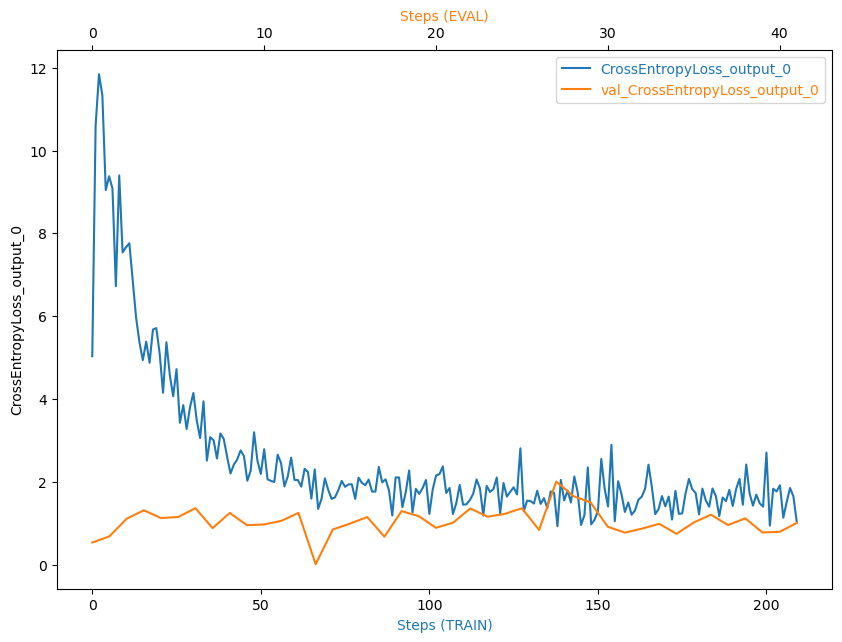

In [27]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [34]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path

's3://sagemaker-us-east-1-379471544283/Image-classification-Project-debugging-2023-10-04-17-40-19-339/rule-output'

In [29]:
! aws s3 ls {rule_output_path} --recursive

2023-10-04 18:18:22     375717 Image-classification-Project-debugging-2023-10-04-17-40-19-339/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-10-04 18:18:21     223673 Image-classification-Project-debugging-2023-10-04-17-40-19-339/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-10-04 18:18:17        192 Image-classification-Project-debugging-2023-10-04-17-40-19-339/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-10-04 18:18:16        200 Image-classification-Project-debugging-2023-10-04-17-40-19-339/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-10-04 18:18:16       1845 Image-classification-Project-debugging-2023-10-04-17-40-19-339/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-10-04 18:18:16        127 Image-classification-Project-debugging-2023-10-04-17-40-19-339/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease

In [43]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-379471544283/Image-classification-Project-debugging-2023-10-04-17-40-19-339/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-379471544283/Image-classification-Project-debugging-2023-10-04-17-40-19-339/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-379471544283/Image-classification-Project-debugging-2023-10-04-17-40-19-339/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-379471544283/Image-classification-Project-debugging-2023-10-04-17-40-19-339/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerRep

In [44]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [47]:
import IPython
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [55]:
estimator = PyTorch.attach('Image-classification-Project-debugging-2023-10-04-17-40-19-339')


2023-10-04 18:18:30 Starting - Preparing the instances for training
2023-10-04 18:18:30 Downloading - Downloading input data
2023-10-04 18:18:30 Training - Training image download completed. Training in progress.
2023-10-04 18:18:30 Uploading - Uploading generated training model
2023-10-04 18:18:30 Completed - Training job completed


In [56]:
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-379471544283/Image-classification-Project-debugging-2023-10-04-17-40-19-339/output/model.tar.gz


In [57]:
from sagemaker.pytorch import PyTorchModel

role = sagemaker.get_execution_role()

model_path = 's3://sagemaker-us-east-1-379471544283/Image-classification-Project-debugging-2023-10-04-17-40-19-339/output/model.tar.gz'
cwd = os.getcwd()
entry_point = os.path.join(cwd,'inference.py')
pytorch_model = PyTorchModel(
    model_data=model_path, 
    role=role, 
    entry_point=entry_point,
    framework_version="1.8",
    py_version="py36"
)

In [58]:
# TODO: Deploy your model to an endpoint
predictor=pytorch_model.deploy(
    initial_instance_count=1, 
    instance_type="ml.t2.medium")  # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: pytorch-inference-2023-10-04-19-52-00-946
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-10-04-19-52-01-770
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-10-04-19-52-01-770


----------!

In [59]:
from sagemaker.s3 import S3Downloader

s3_uri = 's3://sagemaker-us-east-1-379471544283/AWS-IC-Project/dog-breed-dataset/test/'
S3Downloader.download(s3_uri=s3_uri,
                      local_path='test/',
                      sagemaker_session=sagemaker_session)

['test/001.Affenpinscher/Affenpinscher_00003.jpg',
 'test/001.Affenpinscher/Affenpinscher_00023.jpg',
 'test/001.Affenpinscher/Affenpinscher_00036.jpg',
 'test/001.Affenpinscher/Affenpinscher_00047.jpg',
 'test/001.Affenpinscher/Affenpinscher_00048.jpg',
 'test/001.Affenpinscher/Affenpinscher_00058.jpg',
 'test/001.Affenpinscher/Affenpinscher_00071.jpg',
 'test/001.Affenpinscher/Affenpinscher_00078.jpg',
 'test/002.Afghan_hound/Afghan_hound_00116.jpg',
 'test/002.Afghan_hound/Afghan_hound_00125.jpg',
 'test/002.Afghan_hound/Afghan_hound_00139.jpg',
 'test/002.Afghan_hound/Afghan_hound_00141.jpg',
 'test/002.Afghan_hound/Afghan_hound_00143.jpg',
 'test/002.Afghan_hound/Afghan_hound_00146.jpg',
 'test/002.Afghan_hound/Afghan_hound_00149.jpg',
 'test/002.Afghan_hound/Afghan_hound_00151.jpg',
 'test/003.Airedale_terrier/Airedale_terrier_00166.jpg',
 'test/003.Airedale_terrier/Airedale_terrier_00175.jpg',
 'test/003.Airedale_terrier/Airedale_terrier_00179.jpg',
 'test/003.Airedale_terrier/A

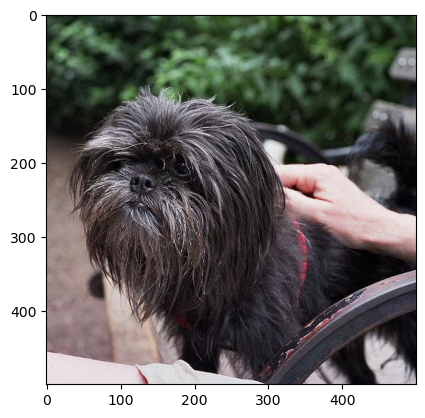

In [72]:
# TODO: Run an prediction on the endpoint

image = plt.imread("test/001.Affenpinscher/Affenpinscher_00047.jpg")# TODO: Your code to load and preprocess image to send to endpoint for prediction
plt.imshow(image)
plt.show()

In [73]:
import requests
from PIL import Image
import io
import torchvision.transforms as T

cwd = os.getcwd()
path = os.path.join(cwd, "test/001.Affenpinscher/Affenpinscher_00047.jpg")
pil_img = Image.open(path)

# transforms
preprocess = T.Compose([
   T.Resize(256),
   T.CenterCrop(224),
   T.ToTensor(),
   T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

image = preprocess(pil_img).unsqueeze(0)
image.shape

torch.Size([1, 3, 224, 224])

In [74]:
response = predictor.predict(image)

In [75]:
print(response)
print(len(response[0]))



[[  4.5069232   -4.42121124  -8.8685236   -1.59308875   1.13883269
  -16.45491409 -10.36077404  -6.32809019  -6.39619827  -2.99415326
  -10.89970112  -6.2414813  -12.25176716 -11.35238171  -5.16780615
   -8.13334274  -6.18348837  -4.8194952  -27.73361015 -15.50545597
   -4.4342618   -6.88608742  -3.27030635 -13.5871973   -6.86410284
   -4.34032917 -21.57216454 -19.68440247  -7.87644005 -11.9889164
  -11.50151348  -9.11713982 -11.30864906   2.2412703    5.07169676
   -5.98594952  -8.02661419   5.5432024  -14.93461227  -7.93093824
   -4.70922041  -8.58260632  -7.05614853  -0.7863456   -1.70367801
   -0.92595297 -13.59816551   2.03824306  -3.58620739 -15.9696722
  -18.57513046   0.40882614   6.86809683 -18.8764534  -13.18431282
   -6.44103241   1.964818    -5.60253286 -13.68446827  -2.35674405
   -5.89224863  -4.04439163 -17.24076271  -6.28901434 -26.04854774
  -18.73563385 -18.2755909  -15.36171532 -11.93842793  -3.00610256
   -4.19376278   2.24250174   0.12099589  -6.52478027   2.187768

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()